# Case Study: Automatic Ticket Classification

### Effective handling of client complaints is essential for preserving customer happiness and loyalty in the ever-changing world of customer service. Our business has gathered a sizable collection of JSON-formatted consumer complaint data. Sadly, there is currently no labeling for this data, which makes it difficult to quickly route tickets to the relevant departments for resolution. We suggest applying Natural Language Processing (NLP) approaches to create a strong classification system in order to tackle this problem.

### The objective is to develop a model that can automatically classify client complaints into discrete groups according to the goods or services that are referenced in the tickets. This categorization will facilitate efficient ticket administration, guaranteeing that every concern is routed to the appropriate division for prompt and efficient response.

### classify tickets into the following five clusters based on their products/services:

- Credit card / Prepaid card

- Bank account services

- Theft/Dispute reporting

- Mortgages/loans

- Others

### Import Dependencies

In [1]:
# Importing required library
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Importing libraries for text preprocessing and analysis
import re, nltk, spacy, string
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [2]:
#  TextBlob library requires specific data resources (the punkt tokenizer) from the NLTK library
nltk.download('punkt')
#  Download all necessary data for TextBlob
!python -m textblob.download_corpora

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.float_format = '{:.2f}'.format

### Mount the Drive

In [5]:
from google.colab import drive
drive.mount('/content/googledrive')

Mounted at /content/googledrive


### Load data

The data is in JSON format and we need to convert it to a dataframe.

Parse the opened JSON data into Python data structures. Use json_normalize to flatten the data so that dictionaries expand into a flat table.

In [6]:
f = open('/content/googledrive/MyDrive/complaints-2021-05-14_08_16.json')
data = json.load(f)
df = pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.00,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.00,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.00,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.00,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.00,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


### Data preparation

1. Inspect Basic Stats

In [7]:
df.shape

(78313, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

2. Examine Missing Values

In [9]:
(df.isna().sum()[df.isna().sum()>0]*100/len(df)).sort_values(ascending=False, ignore_index=False).to_frame('missing_percentage')

,missing_percentage
_source.company_public_response,99.99
_source.tags,86.08
_source.sub_issue,59.12
_source.sub_product,13.50
_source.zip_code,8.63
_source.state,2.54
_source.consumer_consent_provided,1.29


3. Inspect the DataFrame

In [10]:
df.head(30)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.00,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.00,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.00,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.00,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.00,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.00,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.00,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.00,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.00,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.00,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


4. Print the column names in the dataframe

In [11]:
df.keys()

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

5. Remove the prefix `_source.` and the leading underscore `_` from the column names

In [12]:
df.columns = df.columns.str.replace('^_source\.', '', regex=True).str.lstrip('_')

In [13]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

6. Assign nan in place of blanks in the `complaint_what_happened` column

In [14]:
df.complaint_what_happened.replace('', np.nan, inplace=True)

7. Examine missing values again

In [15]:
(df.isna().sum()[df.isna().sum()>0]*100/len(df)).sort_values(ascending=False, ignore_index=False).to_frame('missing_percentage')

,missing_percentage
company_public_response,99.99
tags,86.08
complaint_what_happened,73.09
sub_issue,59.12
sub_product,13.50
zip_code,8.63
state,2.54
consumer_consent_provided,1.29


8. Remove all rows where `complaint_what_happened` column has missing values

In [16]:
df.dropna(subset='complaint_what_happened', axis=0, inplace=True)
df.shape

(21072, 22)

### Prepare the text for topic modeling

1. Create a function to **clean** the text and remove all the unnecessary elements.

  - Make the text lowercase
  - Remove text in square brackets
  - Remove punctuation
  - Remove words containing numbers

In [17]:
def clean_text(text):
  # Make the text lowercase
  text = text.lower()
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove words containing numbers
  text = re.sub(r'\b\w*\d\w*\b', '', text)
  # Remove extra whitespace
  text = ' '.join(text.split())
  return text

2. Call the above function to clean the complaints registered

In [18]:
df.complaint_what_happened=df.complaint_what_happened.map(clean_text)

3. Create a function which will help to **Lemmatize** the texts

In [19]:
def lemmatize_text(text):
  lemma_list = []
  document = nlp(text)
  for word in document:
    # Extract lemmas and add it to list
    lemma_list.append(word.lemma_)
  return ' '.join(lemma_list)

4. Create a new column having `lemmatized_complaints`

In [20]:
df['lemmatized_complaints']=df.complaint_what_happened.map(lemmatize_text)

5. Create a dataframe **df_clean** that will have only the complaints and the lemmatized complaints

In [21]:
df_clean = df[['complaint_what_happened', 'lemmatized_complaints']]

In [22]:
df_clean.head(10)

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
15,can you please remove inquiry,can you please remove inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...
20,during the summer months i experience a declin...,during the summer month I experience a decline...
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...


6. Create a function to extract the POS tags.
  - Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"]
  - Prefered ***TextBlob*** which is a Python library used for processing textual data, offering easy access to POS tags and other NLP features. It is created by passing the text into the TextBlob constructor, which converts the text into a TextBlob object. This object is part of the textblob package, which builds on `nltk` and `pattern` libraries.

In [23]:
def pos_tag(text):
  # Create a TextBlob object
  blob = TextBlob(text)
  # Extract POS tags
  pos_tags = blob.tags
  # Keep only words with the 'NN' tag (singular nouns)
  nouns = [word for word, tag in pos_tags if tag == "NN"]
  # Join the list of nouns into a single string
  cleaned_text = ' '.join(nouns)
  return cleaned_text

In [24]:
df_clean["complaint_POS_removed"] = df_clean.lemmatized_complaints.map(pos_tag)

# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom xxxx prob...


 ### Code to visualise the data according to the 'Complaint' character length

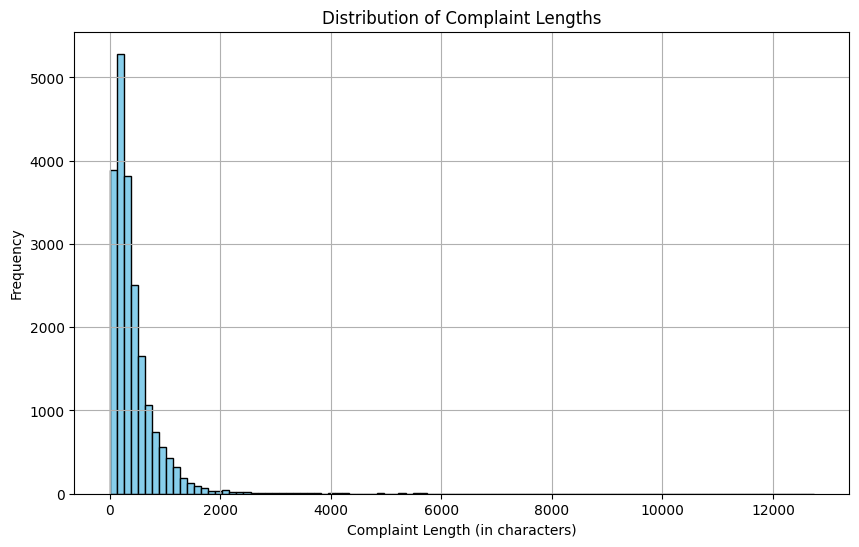

In [25]:
# Visualize the distribution of complaint lengths
plt.figure(figsize=(10, 6))
plt.hist(df_clean["complaint_POS_removed"].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Lengths')
plt.xlabel('Complaint Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Find the top 40 words by frequency among all the articles after processing the text.

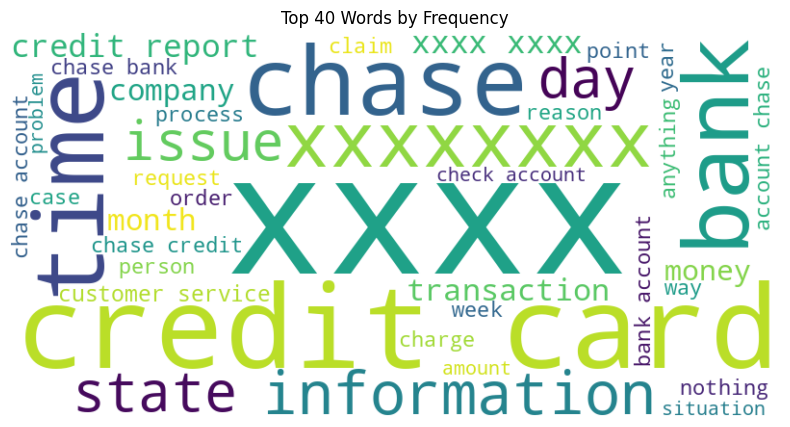

In [26]:
# Combine all articles into a single string
text = ' '.join(df_clean["complaint_POS_removed"].tolist())

# Create and configure the WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()

### Removing -PRON- from the text corpus

In [27]:
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

1. Function to find the top 30 ***unigram*** frequency among the complaints in the cleaned dataframe **df_clean** and plot the same

In [28]:
def plot_top_unigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer
  vectorizer = CountVectorizer()

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each word
  word_freq = X.sum(axis=0).A1
  words = vectorizer.get_feature_names_out()

  # Create a DataFrame with words and their frequencies
  freq_df = pd.DataFrame({'Word': words, 'Frequency': word_freq})

  # Get the top 30 unigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Word', data=top_30, palette='viridis')
  plt.title('Top 30 Unigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.show()

  return freq_df

2. Call the above function **plot_top_unigrams**

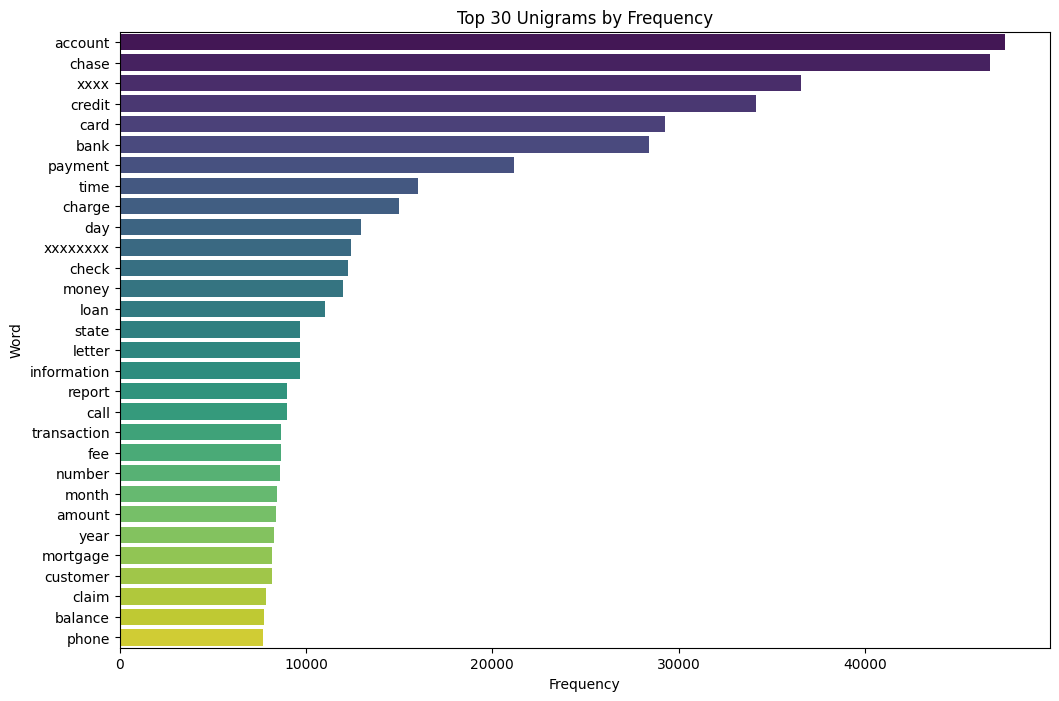

In [29]:
freq_df = plot_top_unigrams(df_clean)

3. Print the top 10 words in the unigram frequency

In [30]:
top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Words by Frequency:", end='\n\n')
print(top_10)

Top 10 Words by Frequency:

          Word  Frequency
99     account      47528
2465     chase      46689
16403     xxxx      36560
3667    credit      34146
2115      card      29278
1259      bank      28405
10709  payment      21166
14989     time      16005
2428    charge      14993
3957       day      12971


4. Function to find the top 30 ***bigram*** frequency among the complaints in the cleaned dataframe **df_clean** and plot the same

In [31]:
def plot_top_bigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer for bigrams
  vectorizer = CountVectorizer(ngram_range=(2, 2))

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each bigram
  bigram_freq = X.sum(axis=0).A1
  bigrams = vectorizer.get_feature_names_out()

  # Create a DataFrame with bigrams and their frequencies
  freq_df = pd.DataFrame({'Bigram': bigrams, 'Frequency': bigram_freq})

  # Get the top 30 bigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Bigram', data=top_30, palette='viridis')
  plt.title('Top 30 Bigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Bigram')
  plt.show()

  return freq_df

5. Call the above function **plot_top_bigrams**

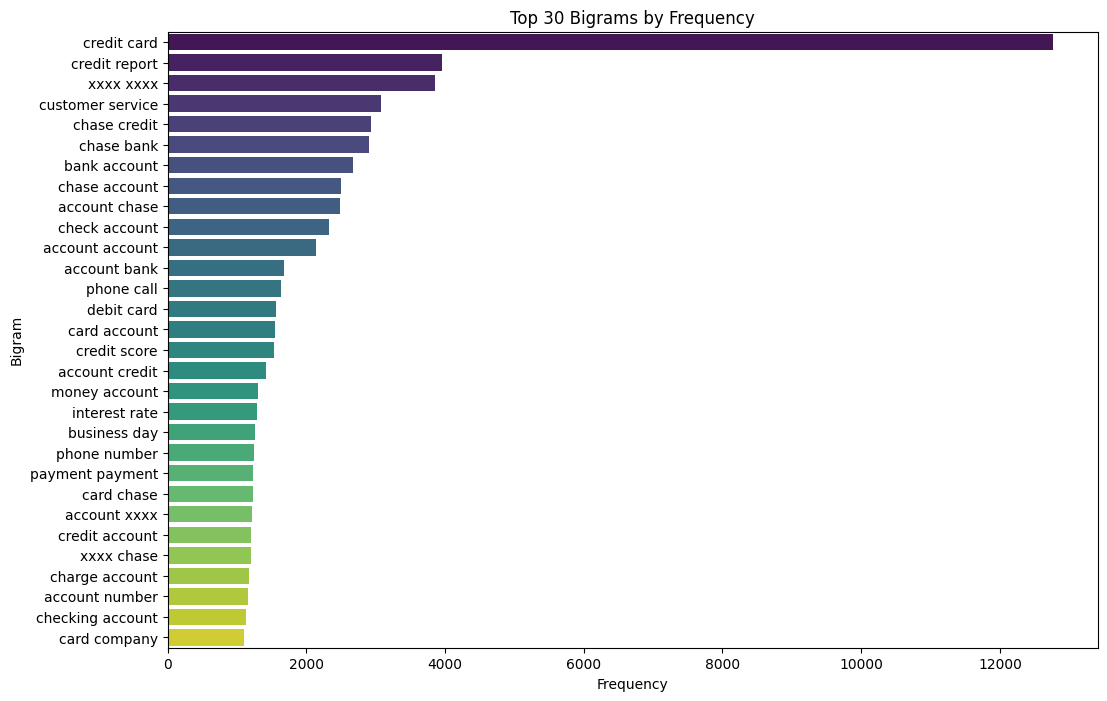

In [32]:
freq_df = plot_top_bigrams(df_clean)

6. Print the top 10 words in the bigram frequency

In [33]:
top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Bigrams by Frequency:", end='\n\n')
print(top_10)

Top 10 Bigrams by Frequency:

                  Bigram  Frequency
80470        credit card      12771
81260      credit report       3953
325216         xxxx xxxx       3852
83837   customer service       3081
55348       chase credit       2926
54961         chase bank       2910
28997       bank account       2675
54755      chase account       2494
2049       account chase       2492
57769      check account       2333


7. Function to find the top 30 ***trigram*** frequency among the complaints in the cleaned dataframe **df_clean** and plot the same

In [34]:
def plot_top_trigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer for trigrams
  vectorizer = CountVectorizer(ngram_range=(3, 3))

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each trigram
  trigram_freq = X.sum(axis=0).A1
  trigrams = vectorizer.get_feature_names_out()

  # Create a DataFrame with trigrams and their frequencies
  freq_df = pd.DataFrame({'Trigram': trigrams, 'Frequency': trigram_freq})

  # Get the top 30 trigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Trigram', data=top_30, palette='viridis')
  plt.title('Top 30 Trigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Trigram')
  plt.show()

  return freq_df

8. Call the function **plot_top_trigrams**

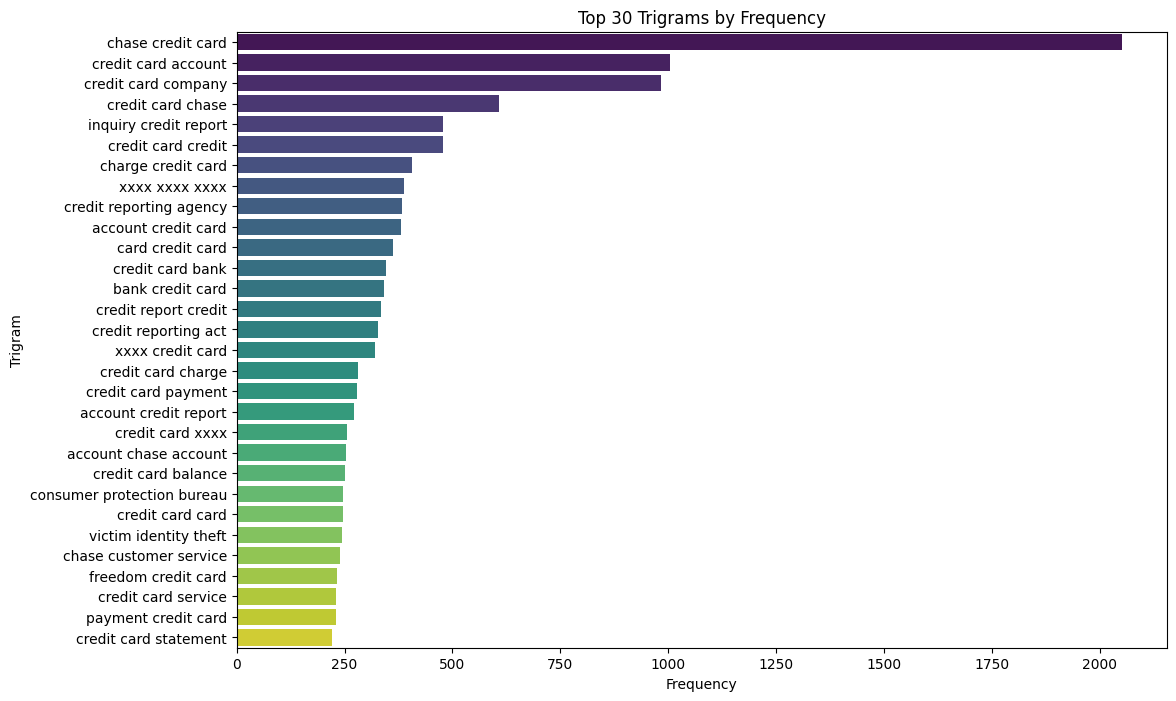

In [35]:
freq_df = plot_top_trigrams(df_clean)

9. Print the top 10 words in the trigram frequency

In [36]:
top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Trigrams by Frequency:", end='\n\n')
print(top_10)

Top 10 Trigrams by Frequency:

                        Trigram  Frequency
182083        chase credit card       2052
257766      credit card account       1003
257978      credit card company        983
257942        credit card chase        608
436955    inquiry credit report        479
258039       credit card credit        477
169157       charge credit card        407
883370           xxxx xxxx xxxx        387
264407  credit reporting agency        384
9977        account credit card        381


### The personal details of customer has been masked in the dataset with **xxxx** and **xxxxxxxx**. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxxxxxx','')

In [38]:
#All masked texts has been removed
df_clean.head(20)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay chase websit...
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...


### Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

1. Initialize the TfidfVectorizer with max_df and min_df

In [39]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

2. Create a document term matrix using fit_transform. <br><br>The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
document_term_matrix = vectorizer.fit_transform(df_clean.Complaint_clean)

### Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names<br><br>

### Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

1. Load your nmf_model with the n_components i.e 5

In [41]:
# write the value you want to test out
num_topics = 5
# keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [42]:
nmf_model.fit(document_term_matrix)

#length of Feature names extracted by TfidfVectorizer
len(vectorizer.get_feature_names_out())

7257

2. Print the Top15 words for each of the topics

In [43]:
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
  top_words_idx = topic.argsort()[-15:][::-1]  # Get indices of top 15 words
  top_words = [feature_names[i] for i in top_words_idx]  # Map indices to feature names
  print(f"Top 15 words from Topic-{topic_idx + 1}:")
  print(", ".join(top_words))
  print()

Top 15 words from Topic-1:
account, bank, check, money, fund, chase, deposit, branch, day, number, business, transaction, claim, transfer, customer

Top 15 words from Topic-2:
credit, card, report, inquiry, chase, account, score, company, limit, information, debt, application, letter, balance, year

Top 15 words from Topic-3:
payment, balance, month, fee, statement, day, time, auto, date, pay, credit, account, chase, year, mortgage

Top 15 words from Topic-4:
charge, card, fee, transaction, dispute, chase, merchant, fraud, claim, purchase, service, time, statement, refund, company

Top 15 words from Topic-5:
loan, mortgage, home, modification, chase, property, year, letter, rate, time, document, bank, house, foreclosure, sale



3. At first Transform the document-term matrix to get topic distribution

In [44]:
topic_distribution = nmf_model.transform(document_term_matrix)

4. Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4. Meaning, get the topic with the highest weight for each complaint

In [45]:
best_topic = topic_distribution.argmax(axis=1)

5. Assign the best topic to each of the cmplaints in Topic Column

In [46]:
df_clean['Topic'] = best_topic

In [47]:
df_clean.head(20)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...,2
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay chase websit...,3
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


6. ***Print the first 5 Complaint for each of the Topics***

In [48]:
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1


### As successfully evaluated the mapping, the topics assigned are correct, so assigning these names to the relevant topic:

  - Credit card / Prepaid card
  - Bank account services
  - Theft/Dispute reporting
  - Mortgages/loans
  - Others

In [49]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,Bank account services
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,Bank account services
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,Bank account services
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Credit card / Prepaid card
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,Credit card / Prepaid card


### Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


### Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

In [53]:
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [54]:
training_data.head(20)

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i c...,1
14,my grand son give me check for i deposit it in...,0
15,can you please remove inquiry,1
17,with out notice jp morgan chase restricted my ...,0
20,during the summer months i experience a declin...,2
21,on xxxx i made a payment to an online retailer...,3
23,i have a chase credit card which is incorrectl...,1


### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

In [55]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

In [56]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

In [57]:
# Create the train & test data using the train_test_split on the tf-idf & topics
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# MODEL - LOGISTIC REGRESSION



In [58]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
logreg.score(X_test, y_test)

0.9147684130599848

**Interpretation**

---

Basline logistic model exhits an accuracy of 91.47%



In [59]:
# Make predictions on test data
y_pred = logreg.predict(X_test)

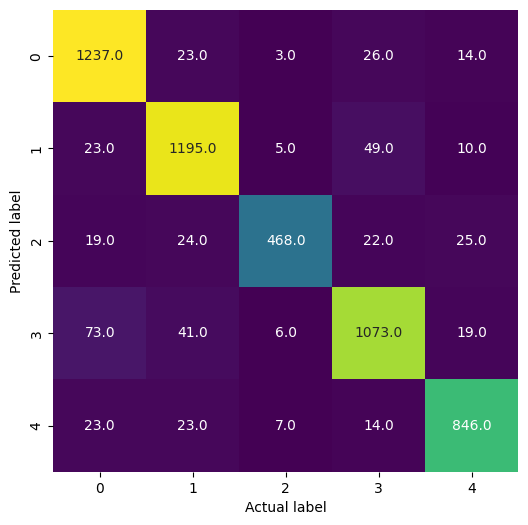

In [60]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [61]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.90      0.95      0.92      1303
Credit card / Prepaid card       0.92      0.93      0.92      1282
                    Others       0.96      0.84      0.89       558
   Theft/Dispute reporting       0.91      0.89      0.90      1212
           Mortgages/loans       0.93      0.93      0.93       913

                  accuracy                           0.91      5268
                 macro avg       0.92      0.91      0.91      5268
              weighted avg       0.92      0.91      0.91      5268



**Interpretation - Logistic Regression**

---

The 91% accuracy rate is fairly good, with a precision and recall of roughly 92% for the Logistic Regression model. Separability across classes appears to be suitably explained by the model.

# MODEL - DECISION TREE

In [64]:
from sklearn.tree import DecisionTreeClassifier

# fitting decision tree with all default hyperparams
decision_tree_classifier = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
decision_tree_classifier.score(X_test, y_test)

0.7830296127562643

In [69]:
dt_grid = {"max_depth": [5, 10, 15],
           "min_samples_split": np.arange(2, 10, 2),
           "min_samples_leaf": np.arange(9, 15, 2)}

# Hyperparameter tuning for Decision Tree
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=3,
                                verbose=True,
                                n_jobs=-1)

dt_hpt.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': array([ 9, 11, 13]),
                         'min_samples_split': array([2, 4, 6, 8])},
             verbose=True)

In [71]:
dt_hpt.best_params_

{'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [70]:
decision_tree_classifier_final = DecisionTreeClassifier(random_state=42, **dt_hpt.best_params_).fit(X_train, y_train)

In [76]:
decision_tree_classifier_final.score(X_test, y_test)

0.7896735003796507

In [73]:
# Make predictions on test data
y_pred = decision_tree_classifier_final.predict(X_test)

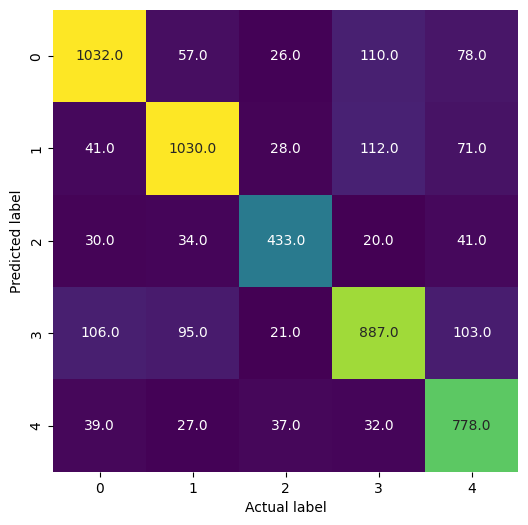

In [74]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [75]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.83      0.79      0.81      1303
Credit card / Prepaid card       0.83      0.80      0.82      1282
                    Others       0.79      0.78      0.79       558
   Theft/Dispute reporting       0.76      0.73      0.75      1212
           Mortgages/loans       0.73      0.85      0.78       913

                  accuracy                           0.79      5268
                 macro avg       0.79      0.79      0.79      5268
              weighted avg       0.79      0.79      0.79      5268



**Interpretation - Decision Tree**

---
A close to 80% accuracy, recall, and precision is achieved based on the selected hyperparameter setting. While it performs better than a random guesser, it falls short of the aforementioned logistic regression model, whose test performance metrics approach 92%.


# MODEL - RANDOM FOREST

In [77]:
from sklearn.ensemble import RandomForestClassifier

# fitting random forest with all default hyperparams
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
rf.score(X_test, y_test)

0.8130220197418375

In [93]:
randomforest_grid = {"n_estimators": [700, 900],
                     "min_samples_split": np.arange(5, 10, 2),
                     "min_samples_leaf": np.arange(5, 10, 2)
                     }

# hyperparameter tuning for Random Forest
random_forest_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                 param_distributions=randomforest_grid,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=-1)


random_forest_hpt.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'min_samples_leaf': array([5, 7, 9]),
                                        'min_samples_split': array([5, 7, 9]),
                                        'n_estimators': [700, 900]},
                   verbose=1)

In [94]:
random_forest_hpt.best_params_

{'n_estimators': 900, 'min_samples_split': 7, 'min_samples_leaf': 5}

In [96]:
random_forest_classifier_final = RandomForestClassifier(random_state=42, **random_forest_hpt.best_params_).fit(X_train, y_train)
random_forest_classifier_final.score(X_test, y_test)

0.8067577828397874

In [97]:
# Make predictions on test data
y_pred = random_forest_classifier_final.predict(X_test)

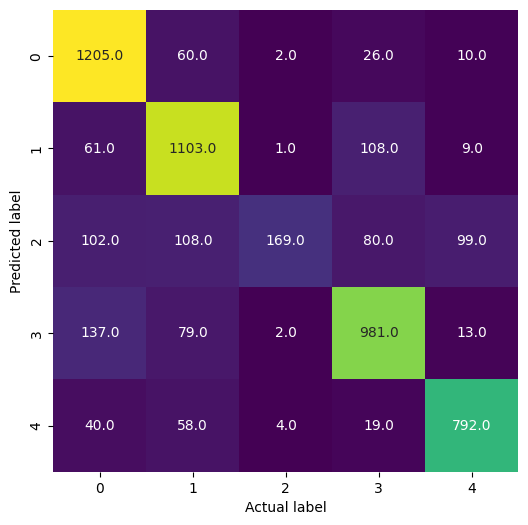

In [98]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [99]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.92      0.85      1303
Credit card / Prepaid card       0.78      0.86      0.82      1282
                    Others       0.95      0.30      0.46       558
   Theft/Dispute reporting       0.81      0.81      0.81      1212
           Mortgages/loans       0.86      0.87      0.86       913

                  accuracy                           0.81      5268
                 macro avg       0.84      0.75      0.76      5268
              weighted avg       0.82      0.81      0.79      5268



**Interpretation - Random Forest**

---
The RandomForest model performs somewhat less well than the logistic regression model based on the hyperparameter that was chosen. Although recall is higher for decision tree, its precision and recall weighted average came out to be 84% and 75%, respectively, higher than decision trees' precision, which resulted in slightly lower weighted f1 score of 76% than that of decision tree.




---


## Conclusion

---
Compared to Decision Tree and Random Forest, the Logistic Regression algorithm produced a better model with wider precision and a recall average of almost 91%, yielding an approximate F1 score of 91%. Therefore, out of the two models, the **logistic regression model is the better option**.